<a href="https://colab.research.google.com/github/oskrivon/cryptoNN/blob/main/ExplosionSearch_CorrectScaler_MixedFeatures_OnlyGrow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.models import load_model

import plotly.graph_objects as go

import pandas as pd
from datetime import datetime

from keras.datasets import mnist
import matplotlib.pyplot as c
import gzip
from typing import List
from sklearn.preprocessing import OneHotEncoder
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

import itertools

import random


#Load dataset and Create dataframe

In [ ]:
dataset = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
dataset = dataset.dropna()

dataset_size = len(dataset)
print('Dataset size:', dataset_size)
dataset.head()

Dataset size: 3613769


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
478,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000
547,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411
548,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000
1224,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000


In [ ]:
def ShowCandlestickChart(dataframe):
  fig = go.Figure(data=[go.Candlestick(x=dataframe['Timestamp'],
                open=dataframe['Open'],
                high=dataframe['High'],
                low=dataframe['Low'],
                close=dataframe['Close'])])
  return fig

In [ ]:
dataframe = dataset.tail(100000)

In [ ]:
ShowCandlestickChart(dataframe.tail(100)).show()

#Create general_testing_processed and general_features

In [ ]:
dataframe = dataframe.reset_index(drop=True)
dataframe = dataframe.drop('Timestamp', 1)
dataframe = dataframe.drop('Weighted_Price', 1)
dataframe = dataframe.drop('Volume_(Currency)', 1)

In [ ]:
dataframe.head()

,Open,High,Low,Close,Volume_(BTC)
0,34613.61,34656.50,34540.00,34554.64,34.037311
1,34582.69,34621.73,34557.16,34579.87,8.071693
2,34609.82,34616.39,34549.70,34567.08,3.638320
3,34561.61,34612.85,34540.19,34561.29,29.269008
4,34561.29,34567.35,34465.99,34467.12,160.924694


# Function declaration

In [ ]:
def CreateDataFrameSet(df, setSize):
  return 1

def ValuesExtractor(df):
  values_ = []
  keys_ = df.columns.tolist()

  for i in keys_:
    values_.append(df[i].values[:])

  values_np = np.array(values_)

  return values_np

def ScalersGenerator(dataCast, parametersNames):
  scalers = dict.fromkeys(parametersNames)
  increment = 0

  for i in parametersNames:
    scalers[i] = MinMaxScaler(feature_range = (0, 1))
    scalers[i] = scalers[i].fit(dataCast[increment].reshape(-1,1))
    increment = increment + 1

  return scalers

def DataNormalizator(data, scalers):
  data_normalized = []
  j = 0

  for i in scalers:
    data_interior = scalers[i].transform(data[j].reshape(-1,1))

    j = j + 1

    data_normalized.append(data_interior)

  data_normalized = np.array(data_normalized)
  return data_normalized

def XYCreator(data, setSize, targetsMarker):
  features_ = []
  targets_ = []

  data = data.transpose()[0]

  j = 0

  for i in range(setSize, len(data)):
    features_.append(data[i-setSize:i])
    targets_.append(data[i][targetsMarker])

  features_np = np.array(features_)
  targets_np = np.array(targets_)

  features_np = features_np.reshape(len(data)-setSize, setSize * dataframe.shape[1]) # 6 = num of colums
  print(dataframe.shape[1])
  targets_np = targets_np.reshape(-1,1)

  return features_np, targets_np

def DataReconstructor(data, scalers):
  data_reshape = data.reshape(-1,dataframe.shape[1]) # 6 = num of colums
  data_reshape = data_reshape.transpose()
  
  data_rescaled = []

  j = 0

  for i in scalers:
    data_rescaled.append(scalers[i].inverse_transform(data_reshape[j].reshape(-1,1)))

    j = j + 1

  return data_rescaled

  ### analis functions

def ShowPredicts(historicalData, target, predict, index):
  data_reconstructed = DataReconstructor(historicalData[index], scalers)

  # 5 - becouse prediction the "Weighted_Price" - see colums name of the dataframe
  hictorical_data = np.append(data_reconstructed[1], target[index])
  prediction_data = np.append(data_reconstructed[1], predict[index])
  
  plt.figure(figsize=(12,6))

  plt.plot(hictorical_data, '-*', color='blue', label='target')
  plt.plot(prediction_data, '--', color='red', label='predict')

  plt.show()

def PredictEvaluation(historicalData, target, predict):
  count = 0

  for i in range(len(historicalData)):
    # 5 - becouse prediction the "Weighted_Price" - see colums name of the dataframe
    x_values = DataReconstructor(historicalData[i], scalers)[1]
    x = x_values[len(x_values) - 1]
    y = target[i]
    pred = predict[i]

    if (y > x and pred > x) or (y < x and pred < x):
      count = count + 1

  return count

# Data preparing

In [ ]:
headlines = dataframe.columns.tolist()

df_row_data = ValuesExtractor(dataframe)

scalers = ScalersGenerator(df_row_data, headlines)

df_data_normal = DataNormalizator(df_row_data, scalers)

# X and Y creating

In [ ]:
setSize = 15

In [ ]:
X, Y = XYCreator(df_data_normal, setSize, 1)

5


#Split data to train and test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.33)
print(len(X_train), len(X_test), len(y_train), len(y_test))

66989 32996 66989 32996


#Create model and fit it

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Dense(input_shape=(setSize * dataframe.shape[1],), units=15, activation='sigmoid'))
model.add(keras.layers.Dense(units=15, activation='sigmoid'))
model.add(keras.layers.Dense(units=15, activation='sigmoid'))
model.add(keras.layers.Dense(1, activation='sigmoid'))


model.summary()

model.compile(optimizer='adam',
              loss='mean_squared_error',
              #loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                1140      
                                                                 
 dense_1 (Dense)             (None, 15)                240       
                                                                 
 dense_2 (Dense)             (None, 15)                240       
                                                                 
 dense_3 (Dense)             (None, 1)                 16        
                                                                 
Total params: 1,636
Trainable params: 1,636
Non-trainable params: 0
_________________________________________________________________


# NN Learning

In [ ]:
history = model.fit(X, Y, validation_split=0.33, epochs=100, batch_size=10)

Epoch 1/100
67000/67000 [==============================] - 188s 3ms/step - loss: 3.7146e-08 - accuracy: 1.4926e-06 - val_loss: 0.0010 - val_accuracy: 3.0303e-06
Epoch 2/100
67000/67000 [==============================] - 189s 3ms/step - loss: 3.7046e-08 - accuracy: 1.4926e-06 - val_loss: 0.0020 - val_accuracy: 3.0303e-06
Epoch 3/100
67000/67000 [==============================] - 184s 3ms/step - loss: 3.6716e-08 - accuracy: 1.4926e-06 - val_loss: 0.0031 - val_accuracy: 3.0303e-06
Epoch 4/100
67000/67000 [==============================] - 191s 3ms/step - loss: 3.6691e-08 - accuracy: 1.4926e-06 - val_loss: 0.0044 - val_accuracy: 3.0303e-06
Epoch 5/100
67000/67000 [==============================] - 193s 3ms/step - loss: 3.6707e-08 - accuracy: 1.4926e-06 - val_loss: 0.0055 - val_accuracy: 3.0303e-06
Epoch 6/100
67000/67000 [==============================] - 182s 3ms/step - loss: 3.6554e-08 - accuracy: 1.4926e-06 - val_loss: 0.0067 - val_accuracy: 3.0303e-06
Epoch 7/100
67000/67000 [=========

In [ ]:
num_of_epoch = len(history.history['loss'])

In [ ]:
from keras.models import load_model

MODEL_PATH = '/content/gdrive/MyDrive/Colab Notebooks/Models/5layers.h5'

model.save(MODEL_PATH)

In [ ]:
MODEL_PATH = '/content/gdrive/MyDrive/Colab Notebooks/Models/5layers.h5'

model = load_model(MODEL_PATH)

313/313 [==============================] - 0s 1ms/step - loss: 362068352.0000 - accuracy: 0.0000e+00


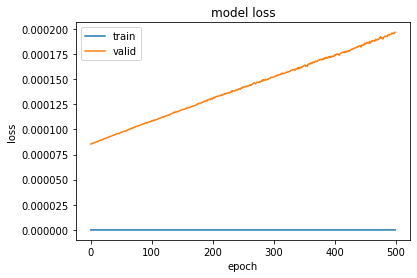

In [ ]:
model.evaluate(X_test, y_test)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

#Make predictions

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 100000)

training_predictions = model.predict(X_test)

training_predictions = scalers['High'].inverse_transform(training_predictions)
y_test = scalers['High'].inverse_transform(y_test)

print(y_test)
print(training_predictions)

[[ 7322.82]
 [ 9288.37]
 [11402.76]
 ...
 [11641.11]
 [ 9113.85]
 [ 9767.3 ]]
[[ 7327.2046]
 [ 9294.281 ]
 [11424.472 ]
 ...
 [11664.276 ]
 [ 9121.761 ]
 [ 9776.848 ]]


# Analysis of results

In [ ]:
diff = abs(y_test - training_predictions)
diff_drop_max = np.delete(diff, np.where(diff == max(diff)))

mean_val = np.mean(abs(y_test - training_predictions))
min_val = min(diff)
max_val = max(diff)

print(diff)
print("mean of abs: ", mean_val, "min : ", min_val, "max: ", max_val)

predictAccuracy = PredictEvaluation(X_test, y_test, training_predictions)
print("accuracy: ", "{0:.2%}".format(predictAccuracy/len(X_test)))

[[ 4.38458984]
 [ 5.91125   ]
 [21.71167969]
 ...
 [23.16636719]
 [ 7.91074219]
 [ 9.54765625]]
mean of abs:  2296.897052288672 min :  [0.00046875] max:  [21433.6309375]
accuracy:  46.93%


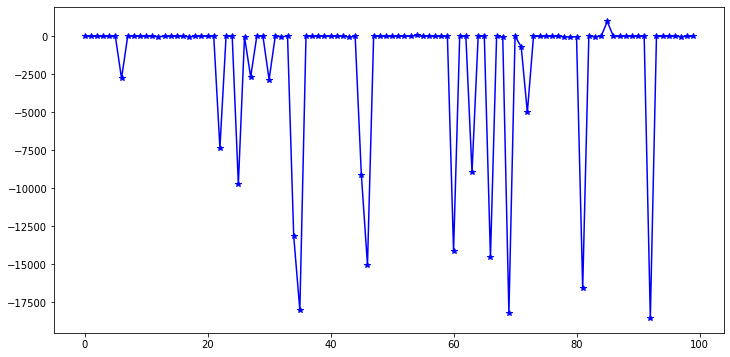

In [ ]:
mean_array = y_test - training_predictions
plt.figure(figsize=(12,6))
plt.plot(mean_array[-100:], '-*', color = 'blue')
plt.show()

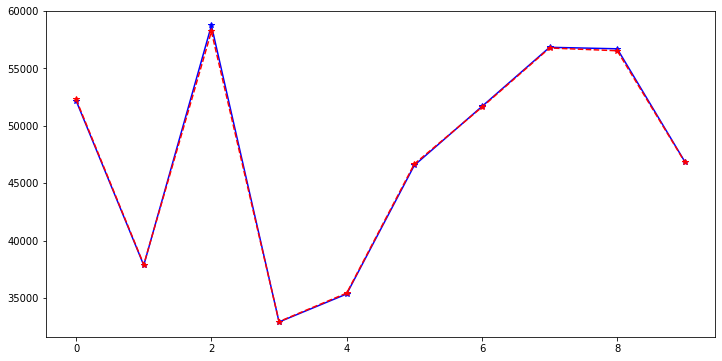

In [ ]:
training_predictions = training_predictions# - mean_val

plt.figure(figsize=(12,6))

plt.plot(y_test[:10], '-*', color='blue', label='target')
plt.plot(training_predictions[:10], '--*', color='red', label='predict')

plt.show()

In [ ]:
predictAccuracy = PredictEvaluation(X_test, y_test, training_predictions)
print("accuracy: ", "{0:.2%}".format(predictAccuracy/len(X_test)))

accuracy:  53.00%


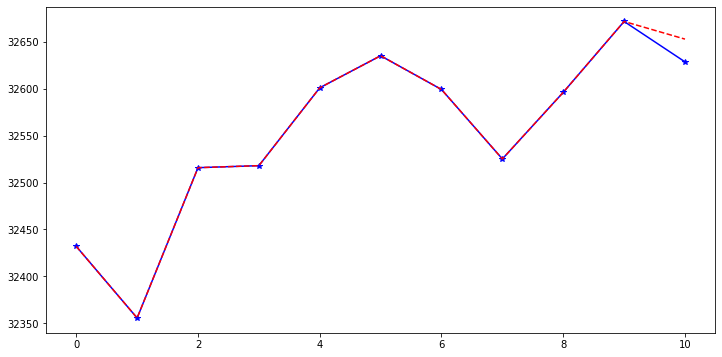

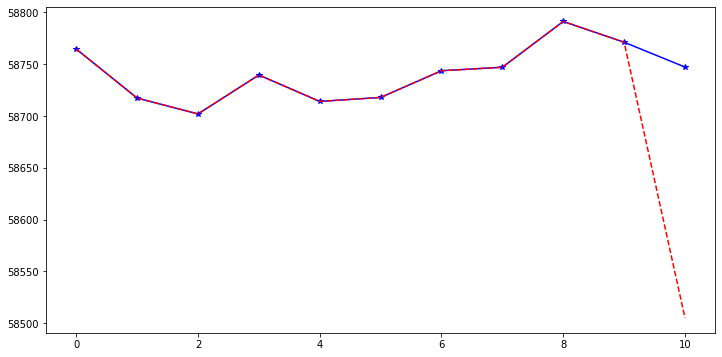

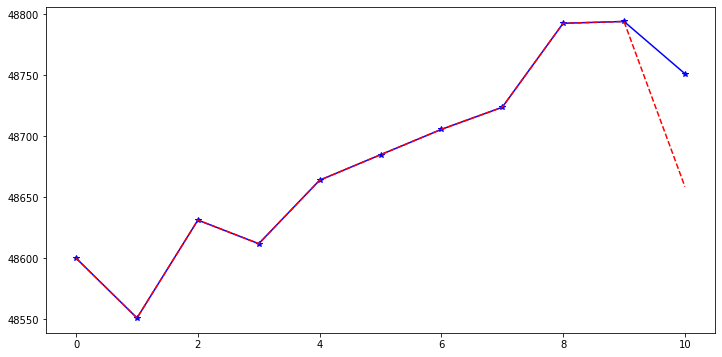

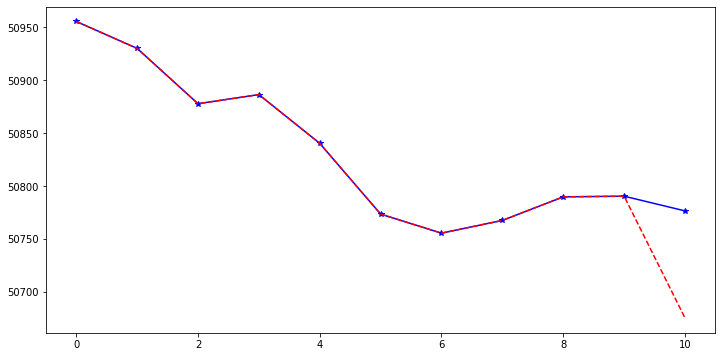

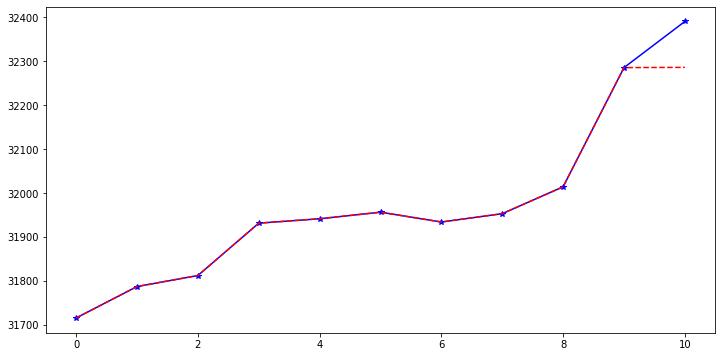

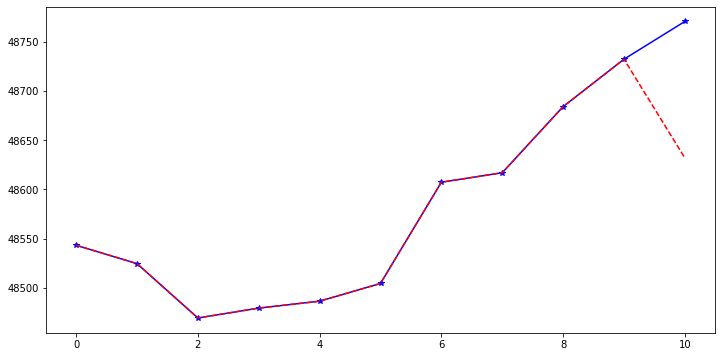

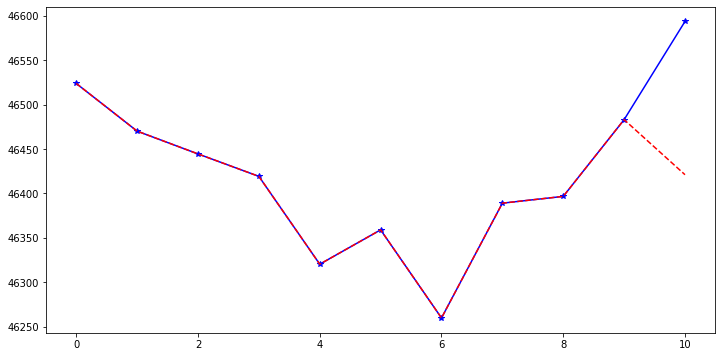

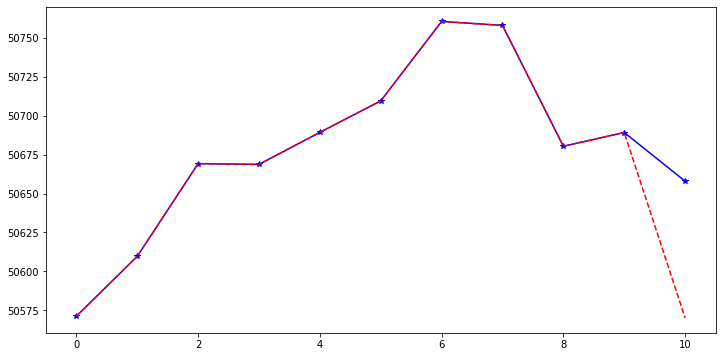

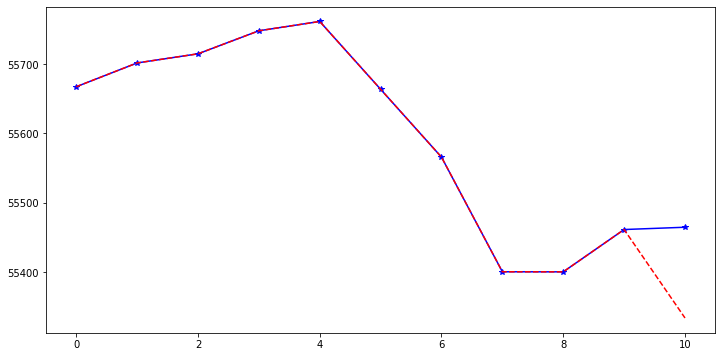

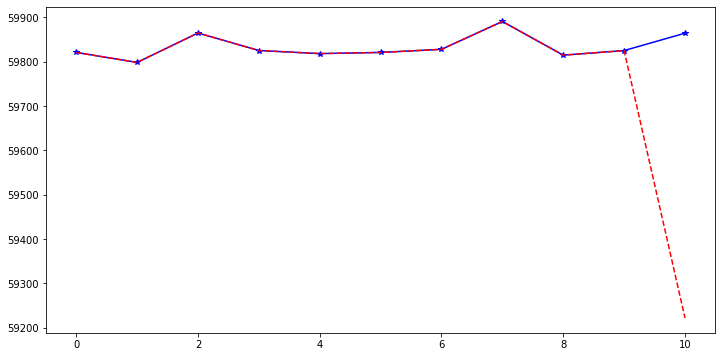

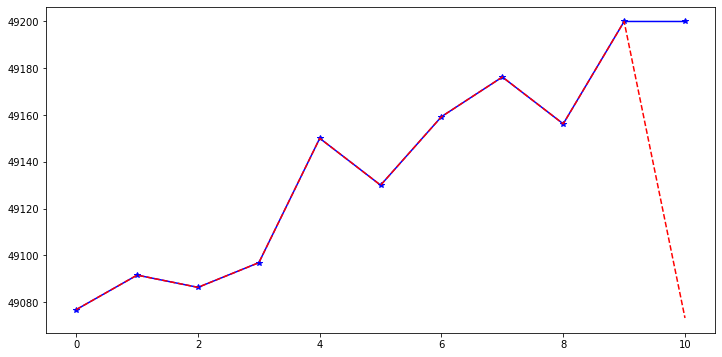

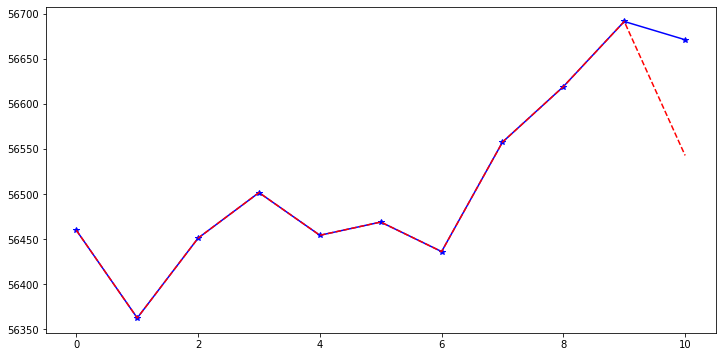

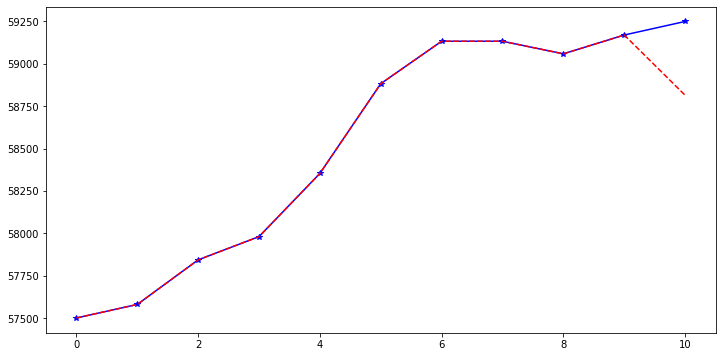

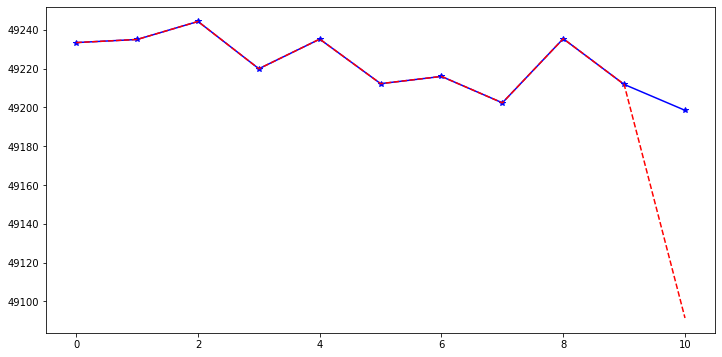

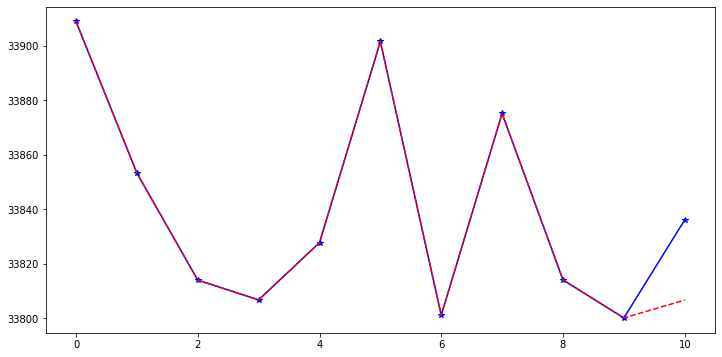

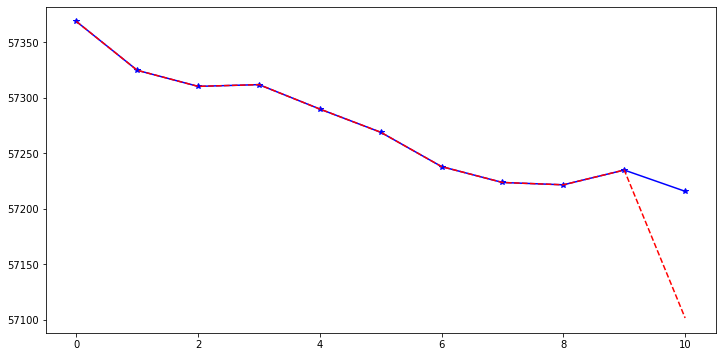

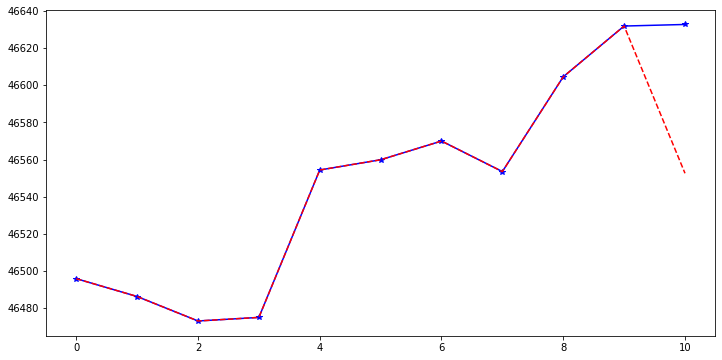

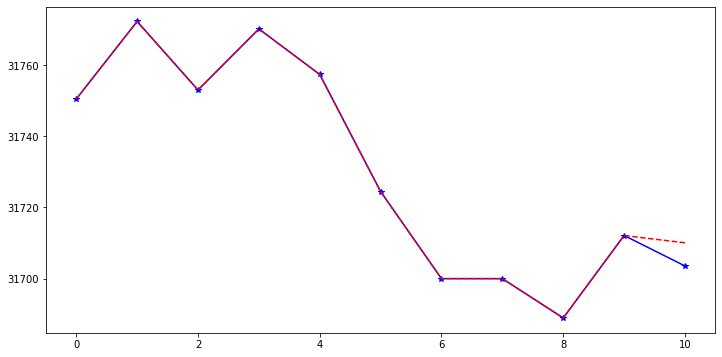

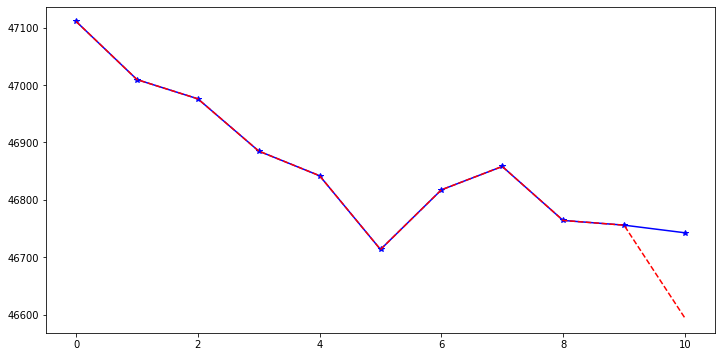

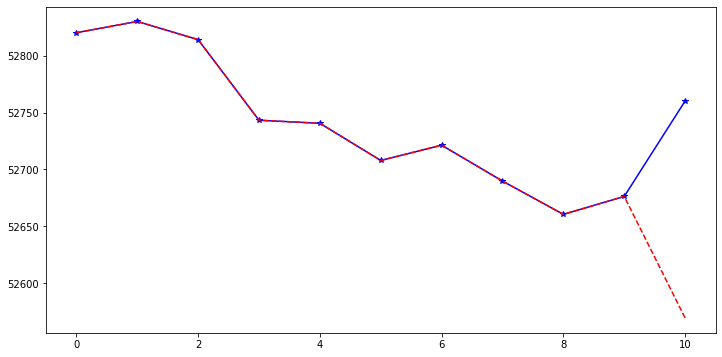

In [ ]:
from random import randint

i = randint(0, len(X_test))

for i in range(i-20, i):
  ShowPredicts(X_test, y_test, training_predictions, i)

# Real testing

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 10000)

training_predictions = model.predict(X)

training_predictions = scalers['High'].inverse_transform(training_predictions)
y = scalers['High'].inverse_transform(Y)

predictAccuracy = PredictEvaluation(X, y, training_predictions)
print("accuracy: ", "{0:.2%}".format(predictAccuracy/len(X)))

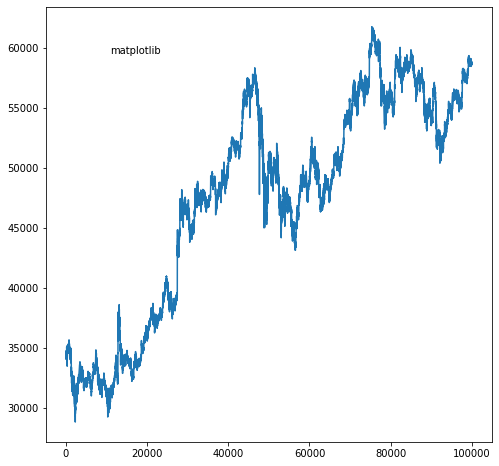

In [ ]:
fig, ax = plt.subplots()

# ax.plot(dataframe['Close'])

ax.text(0.2, 0.9,'matplotlib',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes)

ax.plot(dataframe['Close'])

fig.set_figwidth(8)
fig.set_figheight(8)

plt.show()

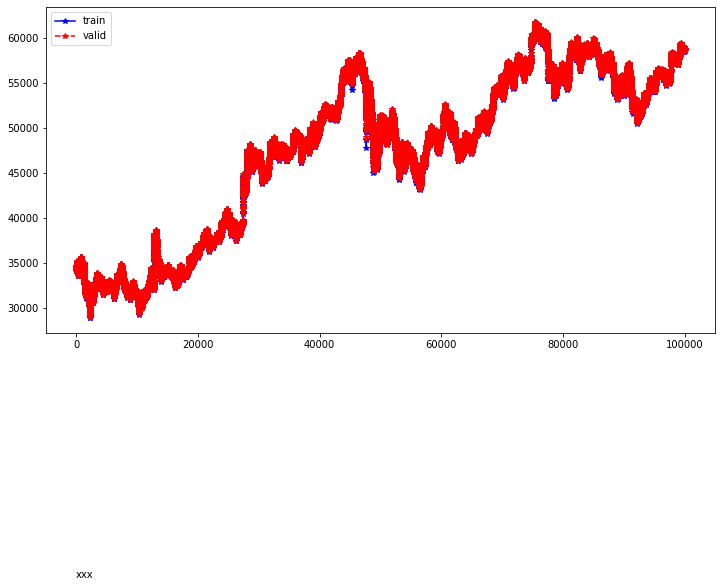

In [ ]:
plt.figure(figsize=(12,6))

# yyy_normal = yyy_normal[:49]
# training_predictions = training_predictions[1:]

plt.plot(dataframe['Close'], '-*', color='blue', label='target')
plt.plot(dataframe['High'], '--*', color='red', label='predict')

num = 10
sss = '/content/gdrive/MyDrive/Colab Notebooks/Models/'
save_path = str(num) + '.png'

SSS = sss + save_path

plt.text(0.5, 0.5, 'xxx')
plt.legend(['train', 'valid'], loc='upper left')

#plt.savefig(SSS)
plt.show()

In [ ]:
i = 50
# xxx = X[-i:]
# yyy = Y[-i:]

a = 10
xxx = X[a:a+i]
yyy = Y[a:a+i]

training_predictions = model.predict(xxx)

#print(training_predictions)

training_predictions = scalers['High'].inverse_transform(training_predictions)
yyy_normal = scalers['High'].inverse_transform(yyy)

# training_predictions = training_predictions[1:]
# yyy_normal = yyy_normal[:i-1]

print(len(yyy_normal), len(training_predictions))

predictAccuracy = PredictEvaluation(xxx, yyy_normal, training_predictions)
print("accuracy: ", "{0:.2%}".format(predictAccuracy/len(xxx)))

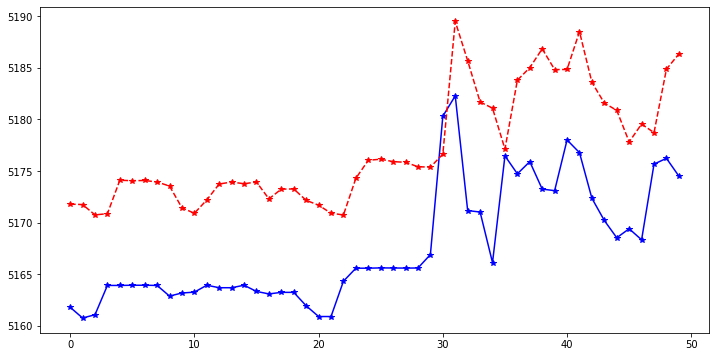

In [ ]:
plt.figure(figsize=(12,6))

# yyy_normal = yyy_normal[:49]
# training_predictions = training_predictions[1:]

plt.plot(yyy_normal, '-*', color='blue', label='target')
plt.plot(training_predictions, '--*', color='red', label='predict')

#plt.savefig('/content/gdrive/MyDrive/Colab Notebooks/Models/1450_epoch_1000bs.png')
plt.show()

In [ ]:
plt.savefig('/content/gdrive/MyDrive/Colab Notebooks/Models/450_epoch.png')


<Figure size 432x288 with 0 Axes>

In [ ]:
plt.show()

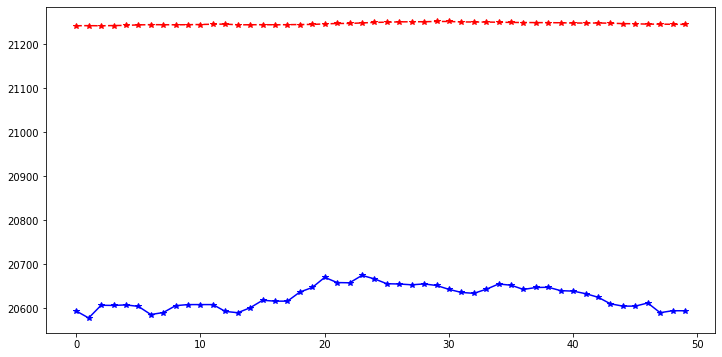

In [ ]:
yyy_normal = yyy_normal - mean_val

plt.figure(figsize=(12,6))

plt.plot(yyy_normal, '-*', color='blue', label='target')
plt.plot(training_predictions, '--*', color='red', label='predict')

plt.show()